In [1]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model

#from keras.utils.vis_utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pickle import dump
import unicodedata

import warnings
warnings.filterwarnings("ignore")

In [2]:
#all_stocks = pd.read_csv('/kaggle/input/btc-usdt/BTC-USDT.csv')
all_stocks = pd.read_csv('dataset.csv')
print(all_stocks.shape)
#all_stocks.drop(columns=["Unnamed: 0"],inplace=True)
#all_stocks.head()

(2193, 7)


In [3]:
stock_df = all_stocks
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [4]:
final_df = stock_df
print(final_df.shape)

(2193, 7)


In [5]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-09-13,235.242004,235.934998,229.332001,230.511993,230.511993,18478800.0
1,2015-09-14,230.608994,232.440002,227.960999,230.643997,230.643997,20997800.0
2,2015-09-15,230.492004,259.182007,229.822006,230.304001,230.304001,19177800.0
3,2015-09-16,230.250000,231.214996,227.401993,229.091003,229.091003,20144200.0
4,2015-09-17,229.076004,230.285004,228.925995,229.809998,229.809998,18935400.0


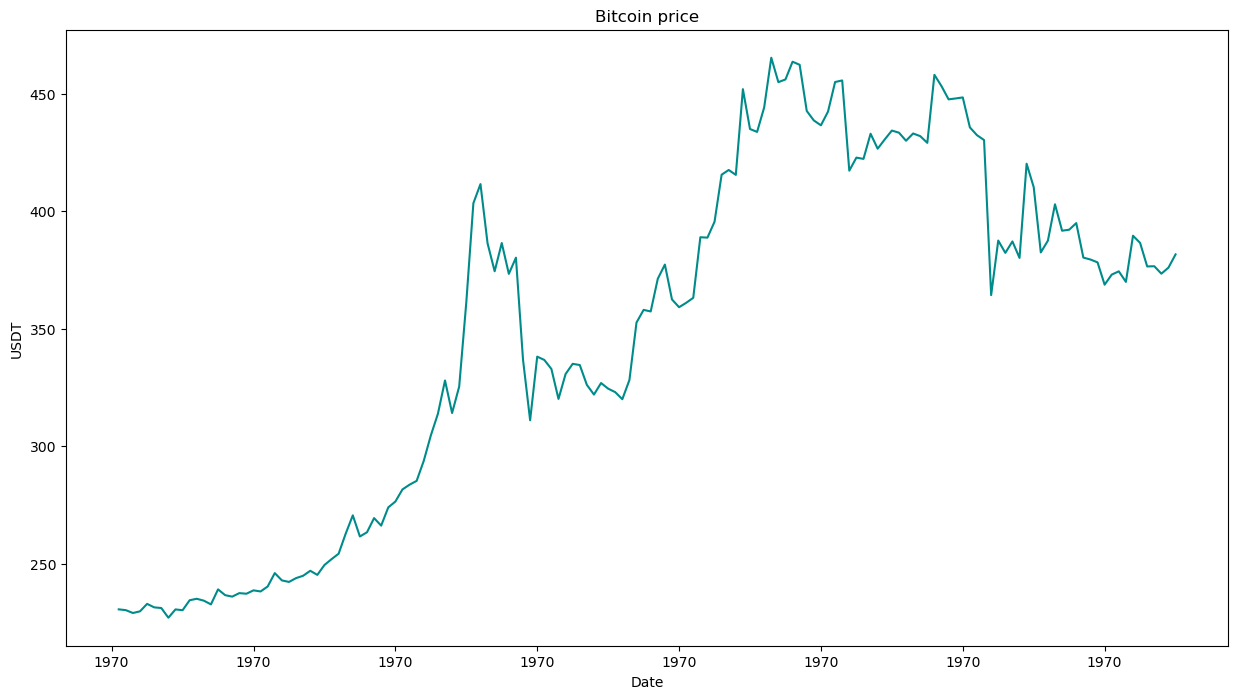

In [49]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(final_df['Date'][1:151], final_df['Close'][1:151], color='#008B8B')
ax.set(xlabel="Date", ylabel="USDT", title="Bitcoin price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()


In [7]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()
    
    data['target'] = data['Close'].shift(-1)
    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [8]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,target,logmomentum
0,2015-10-03,237.201996,239.315002,236.944000,238.729996,238.729996,16482700.0,236.888284,233.28730,-0.701591,3.491067,240.269434,226.305166,238.234119,238.259003,5.471136
1,2015-10-04,238.531006,238.968002,237.940002,238.259003,238.259003,12999000.0,237.674284,233.66805,-0.874353,3.601131,240.870313,226.465788,238.250708,240.382996,5.469152
2,2015-10-05,238.147003,240.382996,237.035004,240.382996,240.382996,23335900.0,237.851569,234.17200,-0.755282,3.805046,241.782092,226.561908,239.672233,246.063004,5.478065
3,2015-10-06,240.363998,246.934998,240.136002,246.063004,246.063004,27535100.0,239.190999,235.02060,-0.470779,4.450110,243.920821,226.120380,243.932747,242.968994,5.501515
4,2015-10-07,246.169998,246.681000,242.585007,242.968994,242.968994,22999200.0,240.177998,235.67855,-1.341140,4.609114,244.896779,226.460321,243.290245,242.304001,5.488810


In [9]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])
dataset.iloc[:, 1:]

,Open,High,Low,Close,Adj Close,Volume,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,target,logmomentum
0,237.201996,239.315002,236.944000,238.729996,238.729996,1.648270e+07,236.888284,233.287300,-0.701591,3.491067,240.269434,226.305166,238.234119,238.259003,5.471136
1,238.531006,238.968002,237.940002,238.259003,238.259003,1.299900e+07,237.674284,233.668050,-0.874353,3.601131,240.870313,226.465788,238.250708,240.382996,5.469152
2,238.147003,240.382996,237.035004,240.382996,240.382996,2.333590e+07,237.851569,234.172000,-0.755282,3.805046,241.782092,226.561908,239.672233,246.063004,5.478065
3,240.363998,246.934998,240.136002,246.063004,246.063004,2.753510e+07,239.190999,235.020600,-0.470779,4.450110,243.920821,226.120380,243.932747,242.968994,5.501515
4,246.169998,246.681000,242.585007,242.968994,242.968994,2.299920e+07,240.177998,235.678550,-1.341140,4.609114,244.896779,226.460321,243.290245,242.304001,5.488810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2168,45774.742188,47261.949219,45669.738281,46391.421875,46391.421875,3.867266e+10,49092.983817,48711.031445,-1205.030104,1697.536847,52106.105140,45315.957751,46568.358930,44883.910156,10.744848
2169,46396.664063,47031.742188,44344.484375,44883.910156,44883.910156,3.915467e+10,48358.488839,48509.952344,-1044.038137,1899.465048,52308.882439,44711.022248,45445.393081,45201.457031,10.711812
2170,44869.839844,45969.292969,44818.265625,45201.457031,45201.457031,3.449984e+10,47680.893415,48303.942578,-664.828295,2026.013272,52355.969121,44251.916035,45282.769048,46063.269531,10.718862
2171,45206.628906,46364.878906,44790.460938,46063.269531,46063.269531,2.788198e+10,46868.016183,48129.798633,-344.346801,2062.967763,52255.734158,44003.863108,45803.102703,44743.929688,10.737749


In [10]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [11]:
def normalize_data(df, range, target_column):

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])
    data.drop(columns=["target"])
    X_scaler = StandardScaler()#feature_range=range
    y_scaler = StandardScaler()#feature_range=range
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)
    
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [12]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [13]:
def split_train_test(data):
    train_size = int(len(data) * 0.8)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [14]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [15]:
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (0,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (2168, 5, 15)
y shape: (2168, 1)
yc shape: (2168, 5, 1)


In [16]:
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]

In [17]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([
        Input(shape=(input_dim, feature_size)),
        LSTM(units = 50, return_sequences = True),
        Dropout(0.2),
        LSTM(units = 60, activation = 'relu', return_sequences = True),
        Dropout(0.3),
        LSTM(units = 80, activation = 'relu', return_sequences = True),
        Dropout(0.4),
        LSTM(units = 120, activation = 'relu'),
        Dropout(0.5),
        Dense(units=output_dim)])
    return model

In [18]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    #cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [19]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [20]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [21]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/bitcoin/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/bitcoin/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())
    
        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)
  
    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [22]:
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

In [23]:
## Test Code

@tf.function 

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [24]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)
    
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for bitcoin", fontsize=20)
    plt.show()


In [110]:
learning_rate = 8e-4
epochs = 2000
square=100;
#g_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
#d_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])

In [27]:
#plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)

In [29]:
#tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model.png', show_shapes=True)

 10%|██████▎                                                        | 50/500 [00:55<05:07,  1.46it/s]

epoch 50 discriminator_loss 1.2488856 generator_loss 0.8225224


 20%|████████████▍                                                 | 100/500 [01:21<03:32,  1.88it/s]

epoch 100 discriminator_loss 1.3762801 generator_loss 0.69040024


 30%|██████████████████▌                                           | 150/500 [01:47<03:11,  1.83it/s]

epoch 150 discriminator_loss 0.519537 generator_loss 1.4606665


 40%|████████████████████████▊                                     | 200/500 [02:14<02:52,  1.74it/s]

epoch 200 discriminator_loss 1.5360625 generator_loss 0.5841669


 50%|███████████████████████████████                               | 250/500 [02:40<02:12,  1.89it/s]

epoch 250 discriminator_loss 0.99194443 generator_loss 0.91757697


 60%|█████████████████████████████████████▏                        | 300/500 [03:06<01:44,  1.91it/s]

epoch 300 discriminator_loss 0.41436958 generator_loss 3.8278284


 70%|███████████████████████████████████████████▍                  | 350/500 [03:32<01:22,  1.83it/s]

epoch 350 discriminator_loss 1.1537755 generator_loss 1.2301362


 80%|█████████████████████████████████████████████████▌            | 400/500 [03:59<00:54,  1.82it/s]

epoch 400 discriminator_loss 1.104381 generator_loss 1.5953195


 90%|███████████████████████████████████████████████████████▊      | 450/500 [04:25<00:28,  1.78it/s]

epoch 450 discriminator_loss 1.0907438 generator_loss 1.9805377


100%|██████████████████████████████████████████████████████████████| 500/500 [04:51<00:00,  1.72it/s]


epoch 500 discriminator_loss 0.99015164 generator_loss 2.8313148


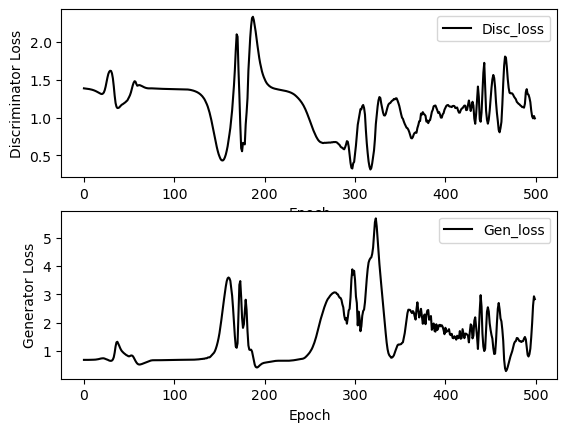

In [30]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, 500, generator, discriminator, g_optimizer, d_optimizer)

In [31]:
test_generator = tf.keras.models.load_model(f'./models_gan/bitcoin/generator_V_399.h5')

In [32]:
predicted = eval_op(test_generator,X_test)

In [98]:
M =df['MA20']
M1=df['Close']

y_scaler = load(open('y_scaler.pkl', 'rb'))
resPr = y_scaler.inverse_transform(predicted)
resR = y_scaler.inverse_transform(y_test)
resPr = M.tolist()
resR = M1.tolist()

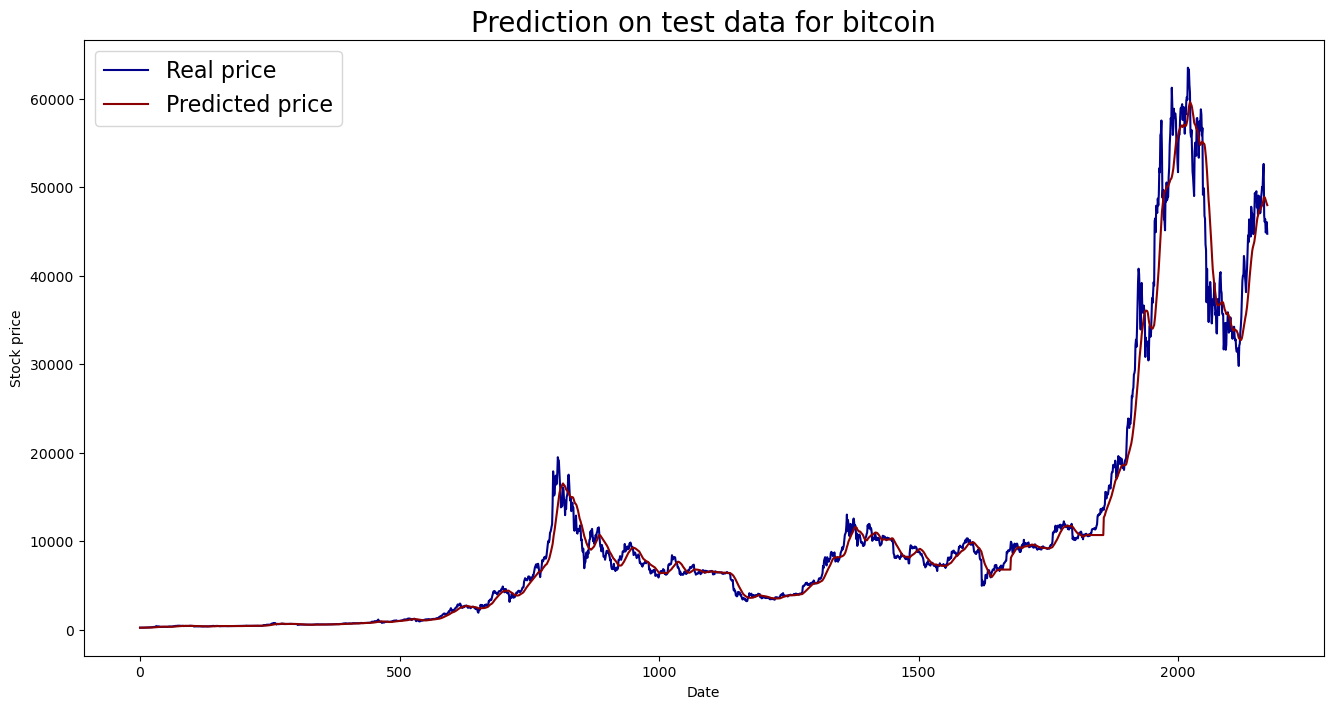

In [99]:

plt.figure(figsize=(16, 8))
plt.plot(resR, color='#00008B')
plt.plot(resPr, color = '#8B0000')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title(f"Prediction on test data for bitcoin", fontsize=20)
plt.show()

Mean Squared Error (MSE): 3638934.0051406194
Root Mean Squared Error (RMSE): 1907.599015815593


In [113]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("MSE",sqrt(sqrt(mean_squared_error(resR, resPr)))/square)
from math import sqrt
from sklearn.metrics import mean_absolute_error
print("RMSE",sqrt(sqrt(sqrt(mean_squared_error(resR, resPr)))/square))


MSE 0.43676069143360335
RMSE 0.6608787267219329
